Energy Disaggregation using Neural Networks
=======================================

In [32]:
import sys
import numpy as np
#sys.path.append("c:/python34/lib/site-packages")
import keras
import pandas as pd
from datetime import datetime as dt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GRU
from keras.layers import Conv2D, Conv1D, MaxPooling2D, LSTM, Bidirectional, BatchNormalization, MaxPooling1D
from keras import regularizers, initializers
import keras.callbacks as cb
from matplotlib import pyplot as plt
import random
import scipy.io

The following functions are used to extract the time and day information from a timestamp value.

In [33]:
def get_month(timevals):
    return dt.fromtimestamp(timevals).month
def get_week(timevals):
    return math.ceil(dt.fromtimestamp(timevals).day/7)
def get_hour(timevals):
    return dt.fromtimestamp(timevals).hour
def get_minute(timevals):
    return dt.fromtimestamp(timevals).minute
def get_second(timevals):
    return dt.fromtimestamp(timevals).second

The following function normalizes each column of the input array by substracting the mean and dividing by the standard deviation.

In [34]:
def normalize_data(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) < 1e-4:
            den = 1e-4
        else:
            den = np.std(X[:,i])
        X[:,i] = (X[:,i]-np.mean(X[:,i]))/den
    return X

This class is used as a callback for the model fit function which is used to calculate and store the losses after each batch iteration.

In [35]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


Model Specification
-------------------------------
The following function is used to create the model.

The following function plots the losses against the epochs.

In [36]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

Data Preprocessing
------------------------------

The following function takes as input the file path, the channel index and the quantity name as input and loads the appropriate data files. It then joins themains and the output quantity based on the timestamp values, extracts time features from the timestamp and splits the input and output into two arrays.

In [6]:
def loadData(path, index, name):
    main11 = np.genfromtxt(path+'channel_1.dat', dtype = [int, float],)
    main12 = np.genfromtxt(path1+'channel_2.dat', dtype = [int, float])
    wash1 = np.genfromtxt(path1+'channel_'+index+'.dat', dtype = [int, float])
    maindf1 = pd.DataFrame(main11)
    maindf1.columns = ["timestamp", "mains1"]
    maindf2 = pd.DataFrame(main12)
    maindf2.columns = ["timestamp", "mains2"]
    washdf1 = pd.DataFrame(wash1)
    washdf1.columns = ["timestamp", name]
    traindf1 = maindf1.merge(maindf2, on = ('timestamp'))
    traindf1 = traindf1.merge(washdf1, how="inner", on = ('timestamp'))
    timevals = traindf1["timestamp"]
    traindf1["month"] = timevals.apply(get_month)
    traindf1["week"] = timevals.apply(get_week)
    traindf1["hour"] = timevals.apply(get_hour)
    traindf1["minute"] = timevals.apply(get_minute)
    traindf1["second"] = timevals.apply(get_second)
    mainR = scipy.io.loadmat("main_real.mat")
    mainI = scipy.io.loadmat("main_img.mat")
    main_real = mainR["main_real"]
    main_img = mainI["main_img"]
    #main_real = np.reshape(main_real,main_real.shape[0])
    #main_img = np.reshape(main_img,main_img.shape[0])
    y = traindf1[name].values
    
    X = np.column_stack((traindf1["month"].values,traindf1["week"].values,
                     traindf1["hour"].values,traindf1["minute"].values,
                     traindf1["second"].values,main_real, main_img))
   
    return X,y

In [37]:
def create_seq(X):
    res = []
    for i in range(0,X.shape[0],1200):
        res.append(X[i:i+1200,:])
    res = np.array(res)
    return res
   

Training and Testing
-------------------------------

The model is trained on the"dishwasher" appliance for house 1. The training set comprises 20000 samples and the testing set comprises 2000 samples. The loss curve is plotted. he predicted values are also plotted against the actual values forthe test set.

House 1:
-------------

In [13]:
path1 = ("low_freq/house_1/")
X, y = loadData(path1, "6", "dishwasher")

y = y.reshape(len(y), 1)
start = random.randrange(0, X.shape[0]-27601)
X_train = X[start:start+24000,:]
y_train = y[start:start+24000,:]

#X_train,y_train = mini_batch(X,y,10000)
X_test = X[start+24001:start+27601,:]
y_test = y[start+24001:start+27601,:]

#X_test,y_test = mini_batch(X,y,1000)
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
#X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


Model Specification
-------------------------------
The following function is used to create the model.

In [14]:
def init_model():
    model = Sequential()
    model.add(Conv1D(16, 4, activation="relu", kernel_initializer="he_normal",
                    input_shape=(1200,7), padding="same", strides=1))
    #model.add(BatchNormalization())
    model.add(Dropout(0.25))
   
    model.add(Bidirectional(LSTM(256, return_sequences=True,
                                  stateful=False), merge_mode='concat'))
    model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='linear'))
    model.add(Dropout(0.25))
    model.compile(loss='mse', optimizer='adam')
    return model

Train on 20 samples, validate on 3 samples
Epoch 1/100
 - 26s - loss: 0.1258 - val_loss: 0.0906
Epoch 2/100
 - 21s - loss: 0.2110 - val_loss: 0.0353
Epoch 3/100
 - 24s - loss: 0.1441 - val_loss: 0.0404
Epoch 4/100
 - 25s - loss: 0.1464 - val_loss: 0.0252
Epoch 5/100
 - 24s - loss: 0.1277 - val_loss: 0.0278
Epoch 6/100
 - 25s - loss: 0.1296 - val_loss: 0.0251
Epoch 7/100
 - 25s - loss: 0.1279 - val_loss: 0.0253
Epoch 8/100
 - 25s - loss: 0.1273 - val_loss: 0.0251
Epoch 9/100
 - 24s - loss: 0.1247 - val_loss: 0.0262
Epoch 10/100
 - 26s - loss: 0.1248 - val_loss: 0.0260
Epoch 11/100
 - 24s - loss: 0.1230 - val_loss: 0.0269
Epoch 12/100
 - 24s - loss: 0.1220 - val_loss: 0.0278
Epoch 13/100
 - 26s - loss: 0.1228 - val_loss: 0.0277
Epoch 14/100
 - 25s - loss: 0.1220 - val_loss: 0.0278
Epoch 15/100
 - 26s - loss: 0.1222 - val_loss: 0.0282
Epoch 16/100
 - 25s - loss: 0.1223 - val_loss: 0.0285
Epoch 17/100
 - 25s - loss: 0.1225 - val_loss: 0.0283
Epoch 18/100
 - 25s - loss: 0.1212 - val_loss: 0

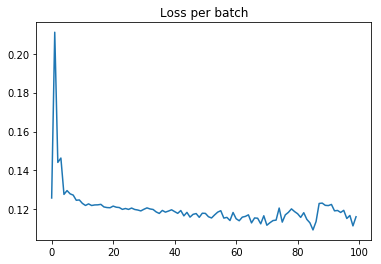

In [15]:
model = init_model()
history = LossHistory()
X_train = create_seq(X_train)
y_train = create_seq(y_train)
X_test = create_seq(X_test)
y_test = create_seq(y_test)
model.fit(X_train, y_train, epochs=100, batch_size=64,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=64)
print(score)
plot_losses(history.losses)

y_pred = model.predict(X_test)

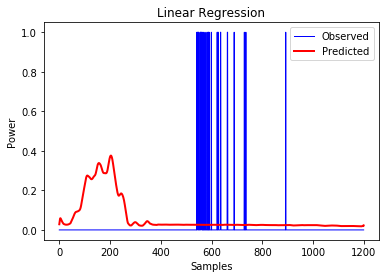

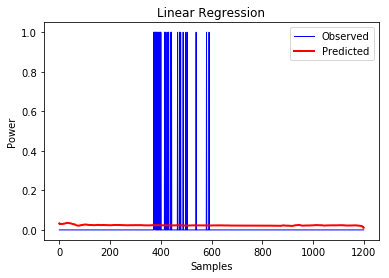

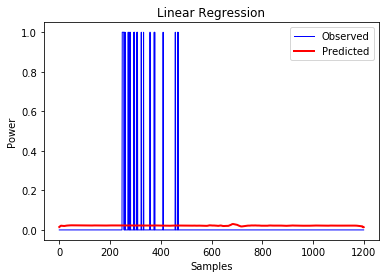

In [16]:
for i in range(len(y_test)):
    samples = range(len(y_test[i]))
    plt.plot(samples,y_test[i], color='blue', linewidth=1, label = 'Observed') 
    plt.plot(samples,y_pred[i], color='red', linewidth=2, label = 'Predicted') 
    plt.title('Linear Regression')
    plt.legend()
    plt.xlabel('Samples')
    plt.ylabel('Power')
    plt.show()

=================================== X ===================================
-----------

House 2: 
-------------    

Data Preprocessing
------------------------------

The following function takes as input the file path, the channel index and the quantity name as input and loads the appropriate data files. It then joins themains and the output quantity based on the timestamp values, extracts time features from the timestamp and splits the input and output into two arrays.

In [40]:
def loadData(path, index, name):
    main11 = np.genfromtxt(path+'channel_1.dat', dtype = [int, float],)
    main12 = np.genfromtxt(path1+'channel_2.dat', dtype = [int, float])
    wash1 = np.genfromtxt(path1+'channel_'+index+'.dat', dtype = [int, float])
    maindf1 = pd.DataFrame(main11)
    maindf1.columns = ["timestamp", "mains1"]
    maindf2 = pd.DataFrame(main12)
    maindf2.columns = ["timestamp", "mains2"]
    washdf1 = pd.DataFrame(wash1)
    washdf1.columns = ["timestamp", name]
    traindf1 = maindf1.merge(maindf2, on = ('timestamp'))
    traindf1 = traindf1.merge(washdf1, how="inner", on = ('timestamp'))
    timevals = traindf1["timestamp"]
    traindf1["month"] = timevals.apply(get_month)
    traindf1["week"] = timevals.apply(get_week)
    traindf1["hour"] = timevals.apply(get_hour)
    traindf1["minute"] = timevals.apply(get_minute)
    traindf1["second"] = timevals.apply(get_second)
   
    #main_real = np.reshape(main_real,main_real.shape[0])
    #main_img = np.reshape(main_img,main_img.shape[0])
    y = traindf1[name].values
    
    X = np.column_stack((traindf1["month"].values,traindf1["week"].values,
                     traindf1["hour"].values,traindf1["minute"].values,
                     traindf1["second"].values,traindf1["mains1"].values,
                     traindf1["mains2"].values))
   
    return X,y

In [41]:
path1 = ("low_freq/house_2/")
X, y = loadData(path1, "10", "dishwasher")
import scipy.io as sio
collect = sio.savemat('saved_data2.mat',{'X': X})


In [42]:
X.shape

(316840, 7)

In [25]:
mainR2 = scipy.io.loadmat("main_real2.mat")
mainI2 = scipy.io.loadmat("main_img2.mat")
main_real = mainR2["main_real"]
main_img = mainI2["main_img"]
X = np.column_stack((X,main_real, main_img))


In [26]:
y = y.reshape(len(y), 1)
start = random.randrange(0, X.shape[0]-27601)
X_train = X[start:start+24000,:]
y_train = y[start:start+24000,:]

#X_train,y_train = mini_batch(X,y,10000)
X_test = X[start+24001:start+27601,:]
y_test = y[start+24001:start+27601,:]

#X_test,y_test = mini_batch(X,y,1000)
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
#X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Model Specification
-------------------------------
The following function is used to create the model.

In [27]:
def init_model():
    model = Sequential()
    model.add(Conv1D(16, 4, activation="relu", kernel_initializer="he_normal",
                    input_shape=(1200,7), padding="same", strides=1))
    #model.add(BatchNormalization())
    model.add(Dropout(0.25))
   
    model.add(Bidirectional(LSTM(256, return_sequences=True,
                                  stateful=False), merge_mode='concat'))
    model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64, return_sequences=True, stateful=False), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='linear'))
    model.add(Dropout(0.25))
    model.compile(loss='mse', optimizer='adam')
    return model

Train on 20 samples, validate on 3 samples
Epoch 1/100
 - 39s - loss: 0.0460 - val_loss: 0.1467
Epoch 2/100
 - 30s - loss: 0.1522 - val_loss: 0.0694
Epoch 3/100
 - 31s - loss: 0.0720 - val_loss: 0.0551
Epoch 4/100
 - 32s - loss: 0.0493 - val_loss: 0.0584
Epoch 5/100
 - 33s - loss: 0.0501 - val_loss: 0.0489
Epoch 6/100
 - 33s - loss: 0.0430 - val_loss: 0.0491
Epoch 7/100
 - 32s - loss: 0.0455 - val_loss: 0.0490
Epoch 8/100
 - 31s - loss: 0.0435 - val_loss: 0.0502
Epoch 9/100
 - 33s - loss: 0.0426 - val_loss: 0.0509
Epoch 10/100
 - 32s - loss: 0.0422 - val_loss: 0.0494
Epoch 11/100
 - 33s - loss: 0.0422 - val_loss: 0.0484
Epoch 12/100
 - 33s - loss: 0.0418 - val_loss: 0.0483
Epoch 13/100
 - 33s - loss: 0.0416 - val_loss: 0.0485
Epoch 14/100
 - 32s - loss: 0.0410 - val_loss: 0.0491
Epoch 15/100
 - 32s - loss: 0.0406 - val_loss: 0.0491
Epoch 16/100
 - 33s - loss: 0.0405 - val_loss: 0.0488
Epoch 17/100
 - 34s - loss: 0.0403 - val_loss: 0.0485
Epoch 18/100
 - 33s - loss: 0.0402 - val_loss: 0

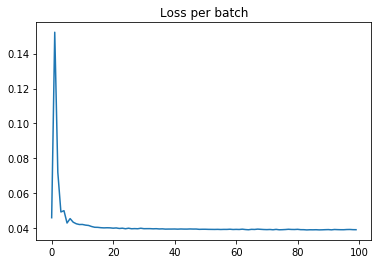

In [28]:
model = init_model()
history = LossHistory()
X_train = create_seq(X_train)
y_train = create_seq(y_train)
X_test = create_seq(X_test)
y_test = create_seq(y_test)
model.fit(X_train, y_train, epochs=100, batch_size=64,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=64)
print(score)
plot_losses(history.losses)

y_pred = model.predict(X_test)

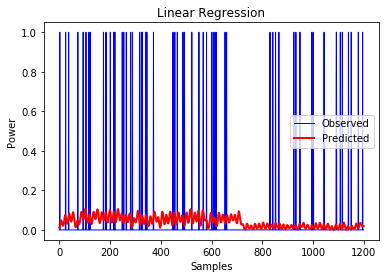

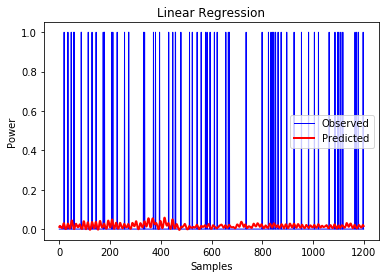

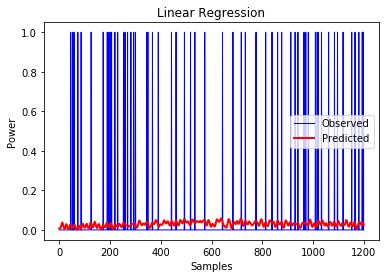

In [31]:
for i in range(len(y_test)):
    samples = range(len(y_test[i]))
    plt.plot(samples,y_test[i], color='blue', linewidth=1, label = 'Observed') 
    plt.plot(samples,y_pred[i], color='red', linewidth=2, label = 'Predicted') 
    plt.title('Linear Regression')
    plt.legend()
    plt.xlabel('Samples')
    plt.ylabel('Power')
    plt.show()

================================ X ================================
------

In [24]:
mainR = scipy.io.loadmat('main_real.mat')
mainI = scipy.io.loadmat('main_img.mat')
main_real = mainR['main_real']
main_img = mainI['main_img']

In [25]:
main_img.shape

(406748, 1)

In [9]:
path1 = ("low_freq/house_2/")
X, y = loadData(path1, "10", "dishwasher")
mainR = scipy.io.loadmat("main_real.mat")
mainI = scipy.io.loadmat("main_img.mat")
main_real = mainR["main_real"]
main_img = mainI["main_img"]

In [10]:
X.shape

(316840, 5)